<a href="https://colab.research.google.com/github/anadiedrichs/2023-nlp-tps/blob/main/6_bot_qa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

Construir QA Bot basado en el ejemplo del traductor pero con un dataset QA.

Recomendaciones:
- MAX_VOCAB_SIZE = 8000
- max_length ~ 10
- Embeddings 300 Fasttext
- n_units = 128
- LSTM Dropout 0.2
- Epochs 30~50

Preguntas interesantes:
- Do you read?
- Do you have any pet?
- Where are you from?

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [12]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [13]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [14]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [15]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [16]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [17]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [18]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

Tokenize the data, to convert the raw text into a sequence of integers. First, we create a Tokenizer object from the keras library and fit it to our text (one tokenizer for the input and another one for the output).


Extract sequence of integers from the text: we call the text_to_sequence method of the tokenizer for every input and output text.


Calculate the maximum length of the input and output sequences.

In [19]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

Tokenizar las oraciones de entrada

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

MAX_VOCAB_SIZE = 8000

input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Nro total de palabras únicas como input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Longitud de la oración más larga en el input: %g" % max_input_len)

Nro total de palabras únicas como input: 1799
Longitud de la oración más larga en el input: 9


Tokenizar oraciones de salida del encoder

In [22]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Nro total de palabras únicas como: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Longitud de la oración más larga en el output: %g" % max_out_len)

Nro total de palabras únicas como: 1806
Longitud de la oración más larga en el output: 10


Por ello:

In [23]:
MAX_LEN = 10

Padding

In [24]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (6033, 9)
encoder_input_sequences[172]: [  0   0   0   1 125   1 125 156 562]


In [25]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (6033, 10)
decoder_input_sequences[172]: [  2   4  57  47 197   3   0   0   0   0]


In [37]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_input_sequences.shape)
print("decoder_output_sequences[172]:", decoder_input_sequences[172])

decoder_output_sequences.shape: (6033, 10)
decoder_output_sequences[172]: [  2   4  57  47 197   3   0   0   0   0]


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [26]:
!wget "https://nlp.stanford.edu/data/glove.6B.zip"


--2023-09-01 01:25:48--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-09-01 01:25:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.44MB/s    in 2m 42s  

2023-09-01 01:28:31 (5.09 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [27]:
! unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [34]:
from numpy import array
from numpy import asarray
from numpy import zeros

# Cargar todo el embedding a memoria
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Cargamos %s vectores de palabras.' % len(embeddings_index))

Cargamos 400000 vectores de palabras.


In [36]:
num_words = len(word2idx_inputs) + 1
EMBEDDING_SIZE = 100
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [33]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

Procesamos como one-hot-encoding la salida final, el Y o target dle modelo

In [38]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [39]:
decoder_targets_one_hot.shape

(6033, 10, 1807)

In [40]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

### 4 - Modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

#### Definir el modelo


ENCODER

In [41]:
LSTM_NODES = 128
LSTM_Dropout = 0.2
EPOCHS = 30


encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

decoder

In [42]:
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [43]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [44]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

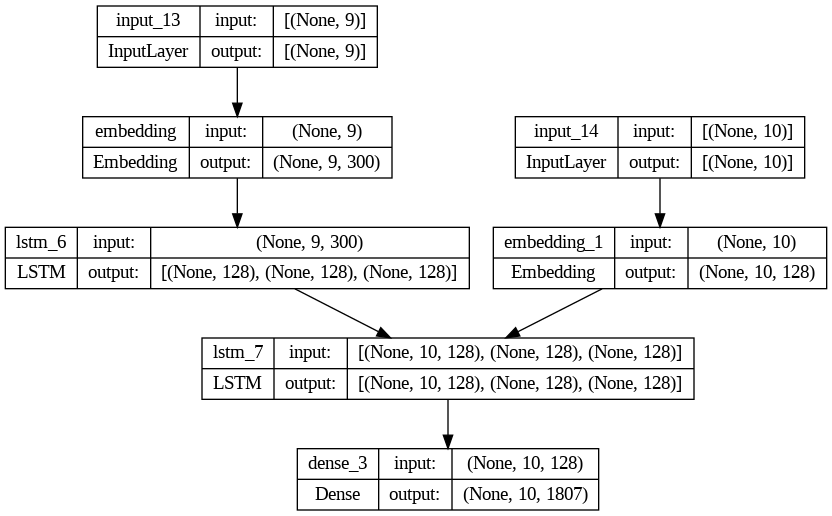

In [45]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

Entrenamiento

In [46]:
BATCH_SIZE = 64

r = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
)

Epoch 1/30
85/85 [==============================] - 15s 117ms/step - loss: 3.3750 - accuracy: 0.4929 - val_loss: 2.5568 - val_accuracy: 0.5306
Epoch 2/30
85/85 [==============================] - 4s 46ms/step - loss: 2.3200 - accuracy: 0.5778 - val_loss: 2.2531 - val_accuracy: 0.6217
Epoch 3/30
85/85 [==============================] - 3s 28ms/step - loss: 2.1181 - accuracy: 0.6249 - val_loss: 2.1500 - val_accuracy: 0.6225
Epoch 4/30
85/85 [==============================] - 2s 20ms/step - loss: 2.0273 - accuracy: 0.6393 - val_loss: 2.0767 - val_accuracy: 0.6389
Epoch 5/30
85/85 [==============================] - 1s 17ms/step - loss: 1.9365 - accuracy: 0.6505 - val_loss: 1.9917 - val_accuracy: 0.6563
Epoch 6/30
85/85 [==============================] - 1s 13ms/step - loss: 1.8450 - accuracy: 0.6783 - val_loss: 1.9085 - val_accuracy: 0.6730
Epoch 7/30
85/85 [==============================] - 1s 14ms/step - loss: 1.7686 - accuracy: 0.6939 - val_loss: 1.8544 - val_accuracy: 0.6843
Epoch 8/30


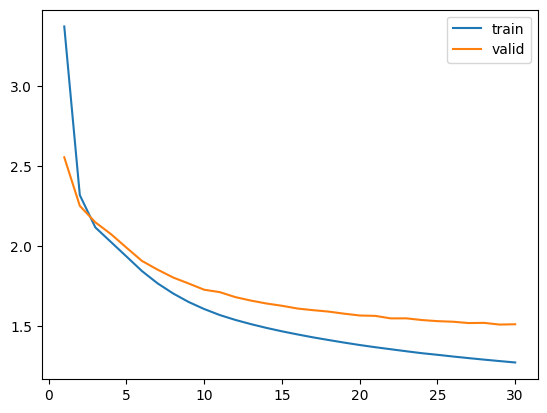

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(r.history['loss']) + 1)
sns.lineplot(x=epoch_count,  y=r.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=r.history['val_loss'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [48]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [49]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [50]:
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [51]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [52]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [53]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

Modelo usado para predecir o inferencia

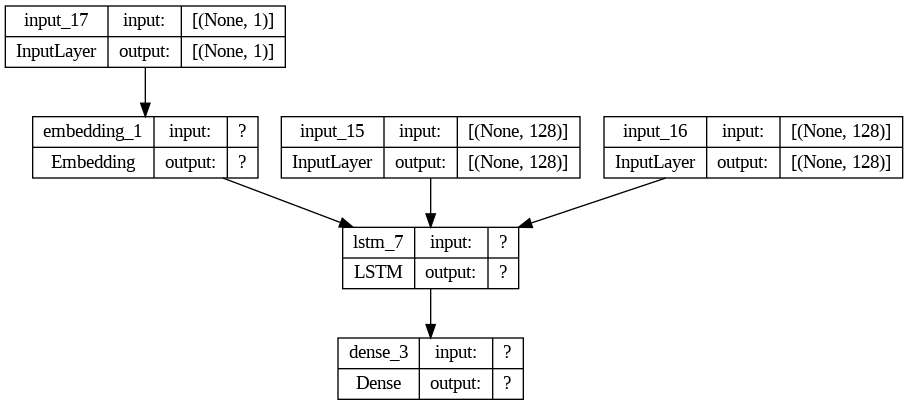

In [54]:
from keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

Para hacer las predicciones, debo hacer un diccionario inverso

In [55]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [56]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [58]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 [==============================] - 0s 23ms/step
-
Input: i love it what do you enjoy 
Response: i like to play video games


## ANEXOS

### Código del sitio machine learning mastery

https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/




In [11]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
        X1, X2, y = list(), list(), list()
        for _ in range(n_samples):
                # generate source sequence
                source = generate_sequence(n_in, cardinality)
                # define padded target sequence
                target = source[:n_out]
                target.reverse()
                # create padded input target sequence
                target_in = [0] + target[:-1]
                # encode
                src_encoded = to_categorical([source], num_classes=cardinality)
                tar_encoded = to_categorical([target], num_classes=cardinality)
                tar2_encoded = to_categorical([target_in], num_classes=cardinality)
                # store
                X1.append(src_encoded)
                X2.append(tar2_encoded)
                y.append(tar_encoded)
        X1 = np.squeeze(array(X1), axis=1)
        X2 = np.squeeze(array(X2), axis=1)
        y = np.squeeze(array(y), axis=1)
        return X1, X2, y

# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
	# define training encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# define training decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# define inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# define inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return all models
	return model, encoder_model, decoder_model

# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
	# encode
	state = infenc.predict(source)
	# start of sequence input
	target_seq = array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
	# collect predictions
	output = list()
	for t in range(n_steps):
		# predict next char
		yhat, h, c = infdec.predict([target_seq] + state)
		# store prediction
		output.append(yhat[0,0,:])
		# update state
		state = [h, c]
		# update target sequence
		target_seq = yhat
	return array(output)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# configure problem
n_features = 50 + 1
n_steps_in = 3
n_steps_out = 3
# define model
train, infenc, infdec = define_models(n_features, n_features, 128)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# generate training dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
print(X1.shape,X2.shape,y.shape)
# train model
train.fit([X1, X2], y, epochs=1)
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	if array_equal(one_hot_decode(y[0]), one_hot_decode(target)):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
# spot check some examples
for _ in range(10):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	print('X=%s y=%s, yhat=%s' % (one_hot_decode(X1[0]), one_hot_decode(y[0]), one_hot_decode(target)))

(100000, 3, 51) (100000, 3, 51) (100000, 3, 51)
1/1 [==============================] - 0s 19ms/step
Accuracy: 100.00%
1/1 [==============================] - 0s 21ms/step
X=[45, 34, 14] y=[14, 34, 45], yhat=[14, 34, 45]
1/1 [==============================] - 0s 19ms/step
X=[12, 25, 7] y=[7, 25, 12], yhat=[7, 25, 12]
1/1 [==============================] - 0s 19ms/step
X=[26, 23, 18] y=[18, 23, 26], yhat=[18, 23, 26]
1/1 [==============================] - 0s 22ms/step
X=[7, 13, 34] y=[34, 13, 7], yhat=[34, 13, 7]
1/1 [==============================] - 0s 30ms/step
X=[46, 10, 17] y=[17, 10, 46], yhat=[17, 10, 46]
1/1 [==============================] - 0s 29ms/step
X=[21, 28, 36] y=[36, 28, 21], yhat=[36, 28, 21]
1/1 [==============================] - 0s 29ms/step
X=[36, 43, 49] y=[49, 43, 36], yhat=[49, 43, 36]
1/1 [==============================] - 0s 29ms/step
X=[33, 5, 42] y=[42, 5, 33], yhat=[42, 5, 33]
1/1 [==============================] - 0s 32ms/step
X=[7, 7, 37] y=[37, 7, 7], yhat